## Flower Classifier

------------------

#### Classifying Flowers with Image data

Data for this analysis comes from Maria-Elena Nilsback and Andrew Zisserman's 2008 study, [“Automated Flower Classification over a Large Number of Classes”](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

The dataset includes 8,192 images of 102 classes of flowers. 

I begin by selecting three flower types and creating a three class classifier. My model classifies very well, with an AUC of .99 and accuracy of .98.

I then create a classifier with all 102 flower classes. This classifier has a high AUC score as well of .97 and accuracy of .57. I plan to work to improve these metrics further, optimizing my model to allow for more complexity and training time.

--------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### open tgz file to get images
### only need to do once
# !tar -xvzf "/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/102flowers.tgz" -C '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/'

In [ ]:
!pip install mat4py

In [ ]:
from mat4py import loadmat
path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/'
im_labels = loadmat(path+'imagelabels.mat')

In [ ]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

     |████████████████████████████████| 22.3MB 62.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import shutil
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
base_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/jpg/'

imagefold = os.path.join(base_path)
file_names = os.listdir(imagefold)
full_path = [os.path.join(imagefold, file_name) for file_name in file_names]
# total number of images

len(full_path)

8192

In [ ]:
# import flower names that correspond with categories
import json
path='/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/'
with open(path+'cat_to_name.json') as f:
  name_cat = json.load(f)

In [ ]:
im_labels = list(im_labels.values())
im_labels = [item for sublist in im_labels for item in sublist]

## Three class classifier

### Set-up training, test, validation datasets

Only need to complete this section once

In [ ]:
# choose the top three flowers with the most images
from collections import Counter
Counter(im_labels).most_common()[:3]

[(51, 258), (77, 251), (46, 196)]

In [ ]:
ind1 = [i for i, j in enumerate(im_labels) if j == 51]
ind2 = [i for i, j in enumerate(im_labels) if j == 77]
ind3 = [i for i, j in enumerate(im_labels) if j == 46]

In [ ]:
# sort list of paths
full_path.sort()

In [1]:
# full_path

In [ ]:
full_path = [full_path[i] for i in ind1 + ind2 + ind3]
im_labels = [im_labels[i] for i in ind1 + ind2 + ind3]

In [ ]:
len(set(im_labels))

3

In [ ]:
len(im_labels)

705

In [ ]:
len(set(full_path))

705

In [ ]:
# ======Train test split resized images====== 
# train = 60%
# validation = 20%
# test = 20%
X_train, X_test, y_train, y_test = train_test_split(
    full_path, im_labels, test_size=0.2, random_state=99)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=99)

In [ ]:
### create new train/validation/test image folders
newpath = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/train_img/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/val_img/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/test_img/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
### move respective images to each folder
train_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/jpg/train_img/'
for file in X_train:
  shutil.copy(file, train_path)

val_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/jpg/val_img/'
for file in X_val:
  shutil.copy(file, val_path)

test_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/jpg/test_img/'
for file in X_test:
  shutil.copy(file, test_path)

In [ ]:
set(y_train)

{46, 51, 77}

In [ ]:
# create classes folder - training
class1path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/train_img/class_1/' 
if not os.path.exists(class1path):
    os.makedirs(class1path)

class2path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/train_img/class_2/' 
if not os.path.exists(class2path):
    os.makedirs(class2path)

class3path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/train_img/class_3/' 
if not os.path.exists(class3path):
    os.makedirs(class3path)

In [ ]:
# create classes folder - validation
class1path_val = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/val_img/class_1/' 
if not os.path.exists(class1path_val):
    os.makedirs(class1path_val)

class2path_val = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/val_img/class_2/' 
if not os.path.exists(class2path_val):
    os.makedirs(class2path_val)

class3path_val = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/val_img/class_3/' 
if not os.path.exists(class3path_val):
    os.makedirs(class3path_val)

In [ ]:
# create classes folder - test
class1path_test = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/test_img/class_1/' 
if not os.path.exists(class1path_test):
    os.makedirs(class1path_test)

class2path_test = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/test_img/class_2/' 
if not os.path.exists(class2path_test):
    os.makedirs(class2path_test)

class3path_test = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/test_img/class_3/' 
if not os.path.exists(class3path_test):
    os.makedirs(class3path_test)

In [ ]:
# move images to class specific folders - train
curr_path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/train_img/'
for x, y in zip(X_train, y_train):
  if y==46:
    shutil.copy(curr_path+x[-15:], class1path)
  if y==51:
    shutil.copy(curr_path+x[-15:], class2path)
  if y==77:
    shutil.copy(curr_path+x[-15:], class3path)

In [ ]:
# move images to class specific folders - validation
curr_path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/val_img/'
for x, y in zip(X_val, y_val):
  if y==46:
    shutil.copy(curr_path+x[-15:], class1path_val)
  if y==51:
    shutil.copy(curr_path+x[-15:], class2path_val)
  if y==77:
    shutil.copy(curr_path+x[-15:], class3path_val)

In [ ]:
# move images to class specific folders - test
curr_path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/jpg/test_img/'
for x, y in zip(X_test, y_test):
  if y==46:
    shutil.copy(curr_path+x[-15:], class1path_test)
  if y==51:
    shutil.copy(curr_path+x[-15:], class2path_test)
  if y==77:
    shutil.copy(curr_path+x[-15:], class3path_test)

### Create ImageDataGenerator


In [ ]:
# set directory paths
p = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/'
train_dir = os.path.join(p, 'jpg/train_img/')
validation_dir = os.path.join(p, 'jpg/val_img/')
test_dir = os.path.join(p, 'jpg/test_img/')

In [ ]:
total_train = 423
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation on training data
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=45,
                                           width_shift_range=.15,
                                           height_shift_range=.15,
                                           horizontal_flip=True,
                                           zoom_range=0.5) 

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir, 
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 423 images belonging to 3 classes.


In [ ]:
validation_image_generator = ImageDataGenerator(rescale=1./255) 

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 141 images belonging to 3 classes.


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1./255) 

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 141 images belonging to 3 classes.


### Visualizing Images

Sample of training images

In [ ]:
sample_training_images,_= next(train_data_gen)

In [ ]:
sample_training_images.shape

(128, 150, 150, 3)

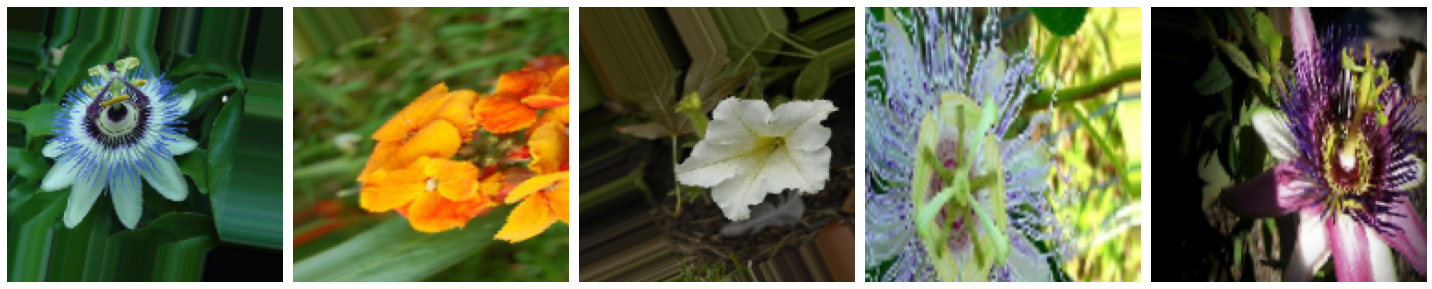

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[5:10])

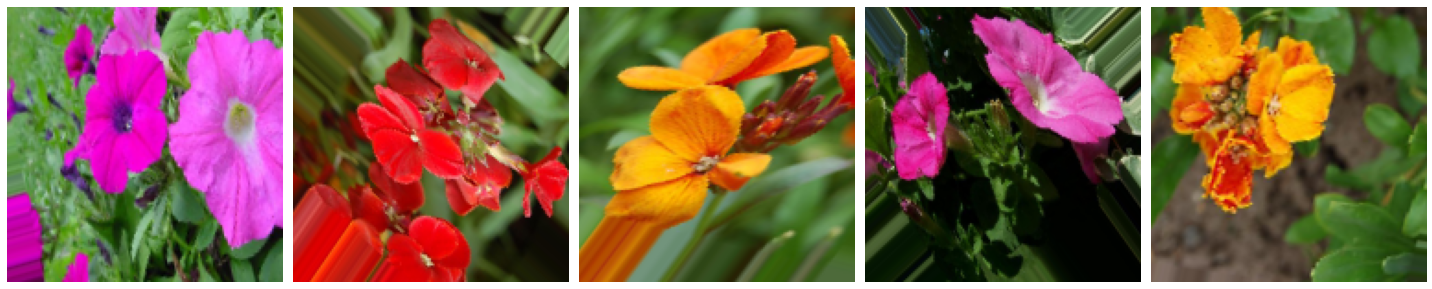

In [ ]:
plotImages(sample_training_images[30:35])

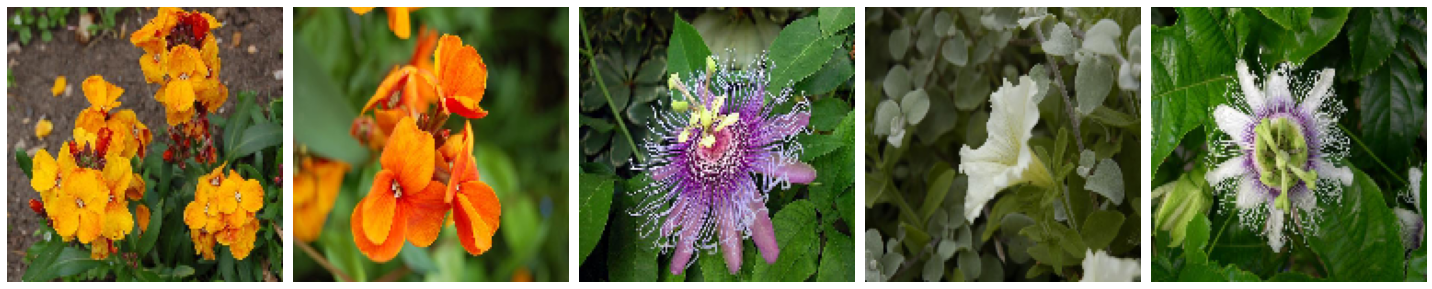

In [ ]:
sample_test_images,_= next(test_data_gen)
plotImages(sample_test_images[5:10])

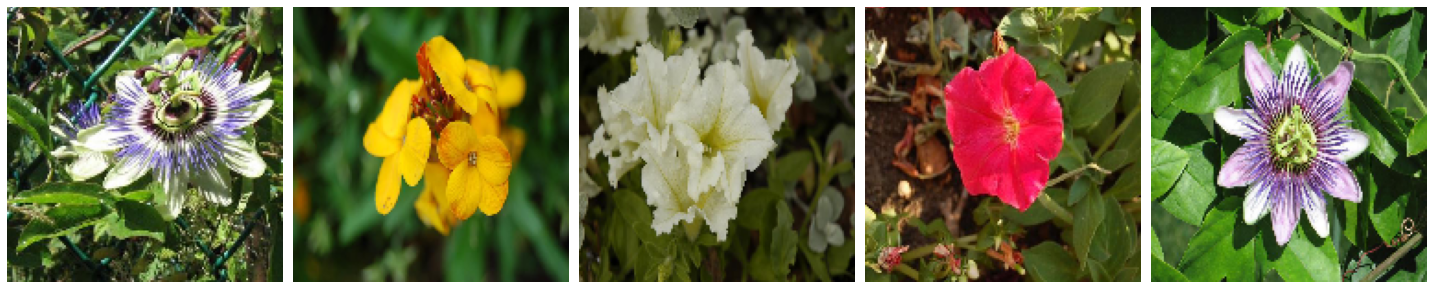

In [ ]:
plotImages(sample_test_images[20:25])

### Modeling

### Squeezenet model

In [ ]:
l = tf.keras.layers
# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

with tf.device('/device:GPU:0'): 
            x = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, 3]) 
            # x (input layer) stacked on top of the convolutional layer
            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(34, 68)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(34, 68)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(34, 68)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(3, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)
        
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'AUC']) 

            history = model.fit(
                      train_data_gen,
                      steps_per_epoch=total_train // batch_size, #adjusts training process for new image batches
                      epochs=150,
                      validation_data=val_data_gen,
                      validation_steps=total_val // batch_size
                  )

Epoch 1/150
13/13 [==============================] - 22s 2s/step - loss: 1.0601 - acc: 0.3524 - auc_2: 0.6036 - val_loss: 0.9972 - val_acc: 0.3901 - val_auc_2: 0.6677
Epoch 2/150
13/13 [==============================] - 17s 1s/step - loss: 0.8746 - acc: 0.5639 - auc_2: 0.7763 - val_loss: 0.8628 - val_acc: 0.5887 - val_auc_2: 0.7648
Epoch 3/150
13/13 [==============================] - 16s 1s/step - loss: 0.7371 - acc: 0.6292 - auc_2: 0.8310 - val_loss: 0.7619 - val_acc: 0.6241 - val_auc_2: 0.8140
Epoch 4/150
13/13 [==============================] - 17s 1s/step - loss: 0.6865 - acc: 0.6774 - auc_2: 0.8583 - val_loss: 0.6648 - val_acc: 0.7021 - val_auc_2: 0.8652
Epoch 5/150
13/13 [==============================] - 15s 1s/step - loss: 0.6214 - acc: 0.7110 - auc_2: 0.8794 - val_loss: 0.6678 - val_acc: 0.6596 - val_auc_2: 0.8663
Epoch 6/150
13/13 [==============================] - 18s 1s/step - loss: 0.5646 - acc: 0.7382 - auc_2: 0.9082 - val_loss: 0.7357 - val_acc: 0.6738 - val_auc_2: 0.888

In [ ]:
score = model.evaluate_generator(generator=test_data_gen,
                           steps=141)
print("Accuracy: ", score[1])
print("AUC: ", score[2])

Accuracy:  0.97869575
AUC:  0.98836595


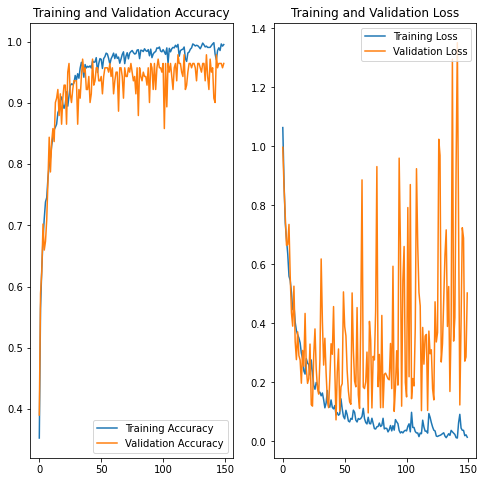

In [ ]:
epochs = 150

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Squeezenet model with batch normalization

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=5, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[150,150, 3]) # input is 150x150 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=96, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(96, 512)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy','AUC'])

  history = model.fit(
          train_data_gen,
          steps_per_epoch=total_train // batch_size, #adjusts training process for new image batches
          epochs=120,
          validation_data=val_data_gen,
          validation_steps=total_val // batch_size
      )

Epoch 1/120
13/13 [==============================] - 185s 14s/step - loss: 0.4867 - acc: 0.8005 - auc_4: 0.9432 - val_loss: 1.1280 - val_acc: 0.3830 - val_auc_4: 0.5129
Epoch 2/120
13/13 [==============================] - 14s 1s/step - loss: 0.1216 - acc: 0.9592 - auc_4: 0.9951 - val_loss: 1.1964 - val_acc: 0.3830 - val_auc_4: 0.5952
Epoch 3/120
13/13 [==============================] - 16s 1s/step - loss: 0.0709 - acc: 0.9778 - auc_4: 0.9985 - val_loss: 1.5409 - val_acc: 0.3830 - val_auc_4: 0.5329
Epoch 4/120
13/13 [==============================] - 16s 1s/step - loss: 0.0643 - acc: 0.9807 - auc_4: 0.9987 - val_loss: 1.6374 - val_acc: 0.3830 - val_auc_4: 0.5590
Epoch 5/120
13/13 [==============================] - 16s 1s/step - loss: 0.0392 - acc: 0.9864 - auc_4: 0.9997 - val_loss: 1.8304 - val_acc: 0.3830 - val_auc_4: 0.5561
Epoch 6/120
13/13 [==============================] - 15s 1s/step - loss: 0.0492 - acc: 0.9885 - auc_4: 0.9986 - val_loss: 1.8905 - val_acc: 0.3830 - val_auc_4: 0.5

In [ ]:
score = model.evaluate_generator(generator=test_data_gen,
                           steps=141)
print("Accuracy: ", score[1])
print("AUC: ", score[2])

Accuracy:  0.90788156
AUC:  0.96686494


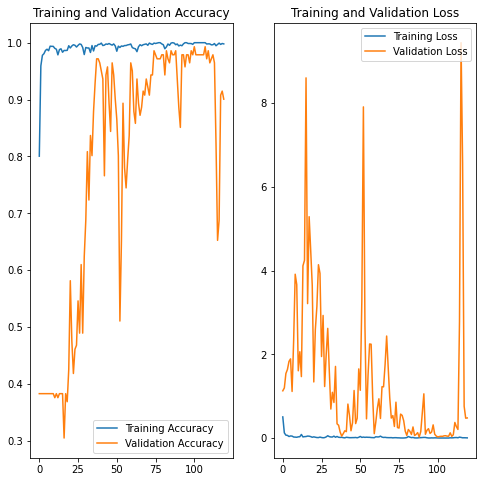

In [ ]:
epochs = 120

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

-------------------

### Evaluation

The best performing model was the Squeezenet model achieving an AUC of 0.9883659 and accuracy of 0.97869575 on test data.


***********************************

## Classifying all flower categories (102 classes)

#### Set-up train, validation, test data for entire dataset of flowers

Only complete this section once

In [ ]:
### open tgz file to get images
### only need to do once
# !tar -xvzf "/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/102flowers.tgz" -C '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers'

In [ ]:
base_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/'

imagefold = os.path.join(base_path)
file_names = os.listdir(imagefold)
full_path = [os.path.join(imagefold, file_name) for file_name in file_names]
# total number of images

len(full_path)

In [ ]:
# import flower names that correspond with categories
import json
path='/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/'
with open(path+'cat_to_name.json') as f:
  name_cat = json.load(f)

In [ ]:
im_labels = list(im_labels.values())
im_labels = [item for sublist in im_labels for item in sublist]

In [ ]:
# sort list of paths
full_path.sort()

In [ ]:
# full_path

In [ ]:
len(set(im_labels))

102

In [ ]:
len(im_labels)

8189

In [ ]:
len(set(full_path))

8189

In [ ]:
# ======Train test split resized images====== 
# train = 60%
# validation = 20%
# test = 20%
X_train, X_test, y_train, y_test = train_test_split(
    full_path, im_labels, test_size=0.2, random_state=99)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=99)

In [ ]:
### create new train/validation/test image folders
newpath = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/train_img/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/val_img/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/test_img/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
### move respective images to each folder
train_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/train_img/'
for file in X_train:
  shutil.copy(file, train_path)

val_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/val_img/'
for file in X_val:
  shutil.copy(file, val_path)

test_path = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/test_img/'
for file in X_test:
  shutil.copy(file, test_path)

Create class folder for train/validation/test images



In [ ]:
# set directory paths
p = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers/'

In [ ]:
# create classes folders in subdirectories
for id in list(set(y_train)):
  os.makedirs(p+'jpg/train_img/'+'class_'+str(id))

for id in list(set(y_train)):
  os.makedirs(p+'jpg/val_img/'+'class_'+str(id))

for id in list(set(y_train)):
  os.makedirs(p+'jpg/test_img/'+'class_'+str(id))

In [ ]:
curr_path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/train_img/'

for file, id in zip(X_train,y_train):
  shutil.copy(curr_path+file[-15:], curr_path+'class_'+str(id)+'/')

In [ ]:
curr_path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/val_img/'

for file, id in zip(X_val,y_val):
  shutil.copy(curr_path+file[-15:], curr_path+'class_'+str(id)+'/')

In [ ]:
curr_path = '/content/drive/MyDrive/Adv. Machine Learning/Code/Final_project/all_flowers/jpg/test_img/'

for file, id in zip(X_test,y_test):
  shutil.copy(curr_path+file[-15:], curr_path+'class_'+str(id)+'/')

### Prepare ImageDataGenerator

In [ ]:
p = '/content/drive/My Drive/Adv. Machine Learning/Code/Final_project/all_flowers/'
train_dir = os.path.join(p, 'jpg/train_img/')
validation_dir = os.path.join(p, 'jpg/val_img/')
test_dir = os.path.join(p, 'jpg/test_img/')

In [ ]:
batch_size = 300
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# I don't include additional data augmention due to the large size of the dataset
train_image_generator = ImageDataGenerator(rescale=1./255) 

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir, # reading in from folder where subfolders are target names
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="categorical")

Found 4913 images belonging to 102 classes.


In [ ]:
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 1638 images belonging to 102 classes.


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data


test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 1638 images belonging to 102 classes.


### Visualizing Images

Sample of training images

In [ ]:
sample_training_images,_= next(train_data_gen)

In [ ]:
sample_training_images.shape

(128, 150, 150, 3)

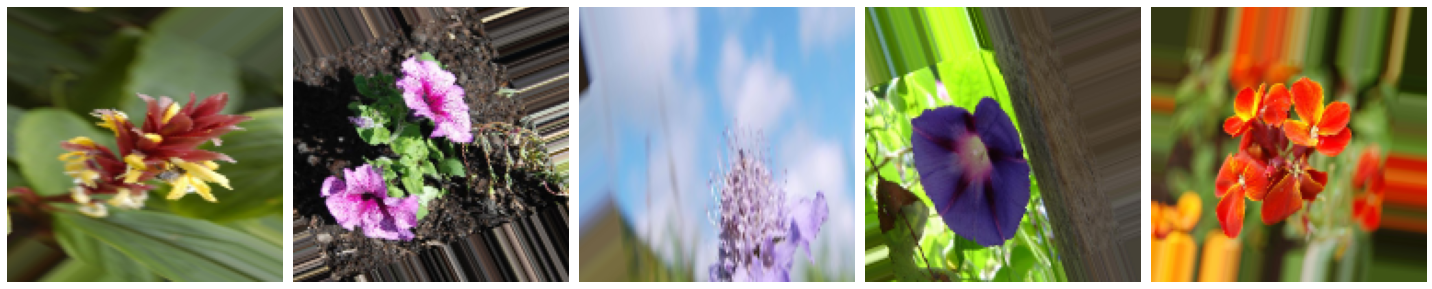

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        # flower_name = name_cat[str(title)]
        # title_str = " ".join(["Label: ",str(title)])
        # ax.set_title("\n".join([title_str,flower_name]), fontdict=None, loc='center', color = "k")
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[5:10])

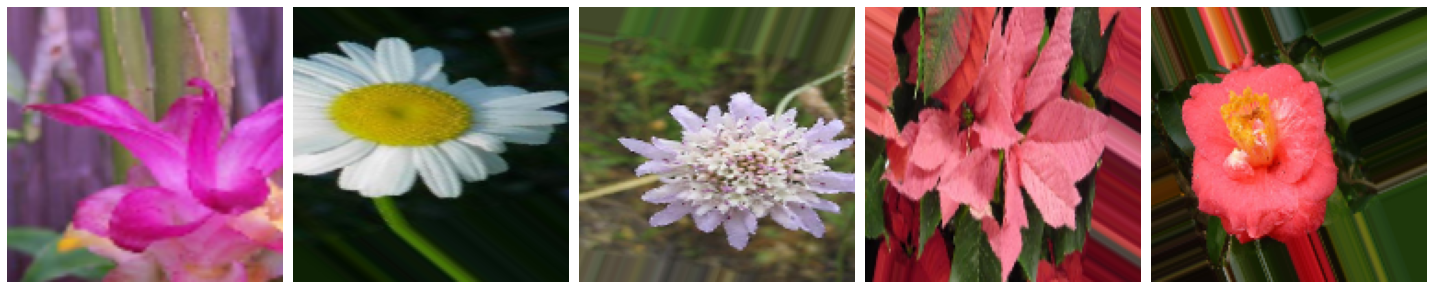

In [ ]:
plotImages(sample_training_images[30:35])

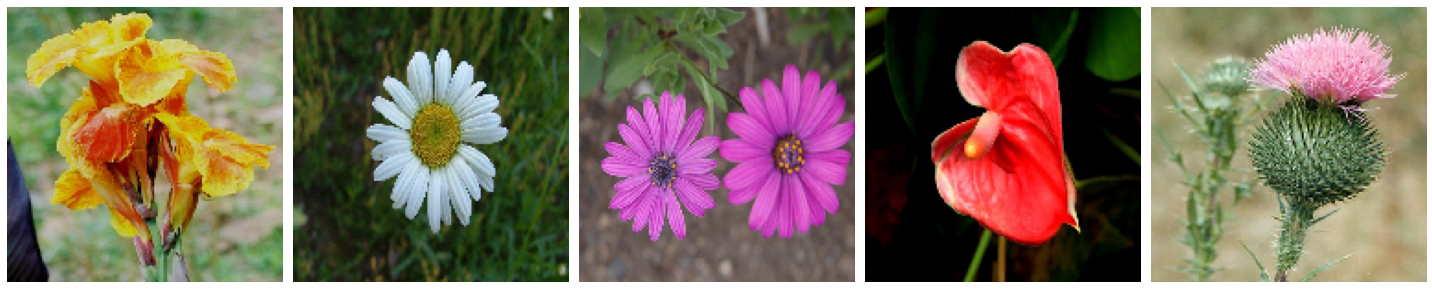

In [ ]:
sample_test_images,_= next(test_data_gen)
plotImages(sample_test_images[5:10])

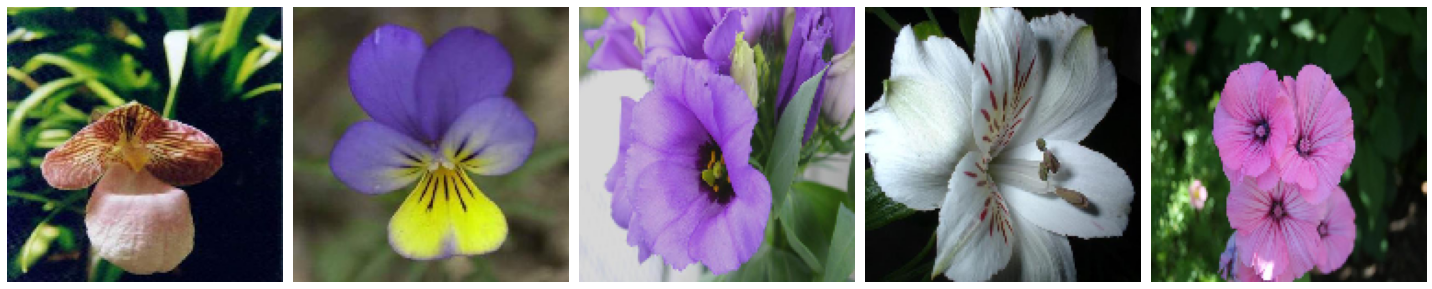

In [ ]:
plotImages(sample_test_images[20:25])

## Modeling

In [ ]:
total_train = 4913
total_val = 1638

### Squeezenet model

In [ ]:
l = tf.keras.layers
# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

with tf.device('/device:GPU:0'): 
    x = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, 3]) 
    # x (input layer) stacked on top of the convolutional layer
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
    y = fire_module(34, 68)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(34, 68)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(34, 68)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
    y = tf.keras.layers.Dense(102, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

    model = tf.keras.Model(x, y)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'AUC']) 
    mc = ModelCheckpoint('best_model.h5', monitor='AUC',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization

    history = model.fit(
              train_data_gen,
              steps_per_epoch=total_train // batch_size, #adjusts training process for new image batches
              epochs=150,
              validation_data=val_data_gen,
              validation_steps=total_val // batch_size,
              callbacks=[mc]
          )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/150
59/59 [==============================] - 2177s 37s/step - loss: 4.5628 - acc: 0.0314 - auc: 0.5786 - val_loss: 4.5356 - val_acc: 0.0287 - val_auc: 0.6002
Epoch 2/150
59/59 [==============================] - 112s 2s/step - loss: 4.4035 - acc: 0.0419 - auc: 0.6678 - val_loss: 4.2706 - val_acc: 0.0441 - val_auc: 0.7085
Epoch 3/150
59/59 [==============================] - 112s 2s/step - loss: 4.0148 - acc: 0.0733 - auc: 0.7822 - val_loss: 3.8810 - val_acc: 0.0777 - val_auc: 0.8139
Epoch 4/150
59/59 [==============================] - 112s 2s/step - loss: 3.7453 - acc: 0.0971 - auc: 0.8377 - val_loss: 3.7094 - val_acc: 0.0906 - val_auc: 0.8463
Epoch 5/150
59/59 [==============================] - 112s 2s/step - loss: 3.5934 - acc: 0.1155 - auc: 0.8598 - val_loss: 3.5542 - val_acc: 0.1164 - val_auc: 0.8616
Epoch 6/150
59/59 [==============================] - 110s 2s/step - loss: 3.4850 - acc: 0.1385 - 

In [ ]:
score = model.evaluate_generator(generator=test_data_gen,
                           steps=141)
print("Accuracy: ", score[1])
print("AUC: ", score[2])

Accuracy:  0.5765123
AUC:  0.9458929


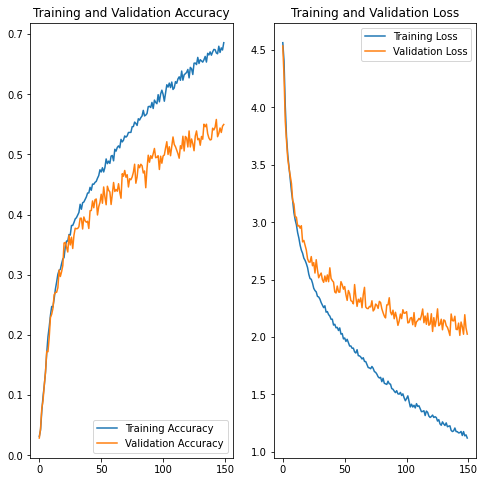

In [ ]:
epochs = 150

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model as a high AUC of .95, but the accuracy is lower than the three class classifier at .57. 


Using the full dataset is much larger, and training time takes much longer. Using Google Colab, my session crashed several times mid-training for other models I had tried testing. I will continue to optimize and train this model to achieve better performance. 

-----------------